<a href="https://colab.research.google.com/github/SMN-SENAMHI/S2S/blob/main/Humedad_relativa_2m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies required for this example.
# If you're not using pip to install depdencies (for example, you're using conda or uv),
# skip this cell and and install using the package manager of your choice.
# Restart the notebook after installing dependencies.
%pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install cython
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... D

/tmp/ipython-input-2-3274630321.py:41: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com")
/tmp/ipython-input-2-3274630321.py:41: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com")


Usando init_time manual: 2025-06-15


/tmp/ipython-input-2-3274630321.py:91: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = np.array([gdf_costa.unary_union.contains(p) for p in points]).reshape(lat2d.shape)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/tmp/ipython-input-2-3274630321.py:91: DeprecationWarning: The 'unary_union' 

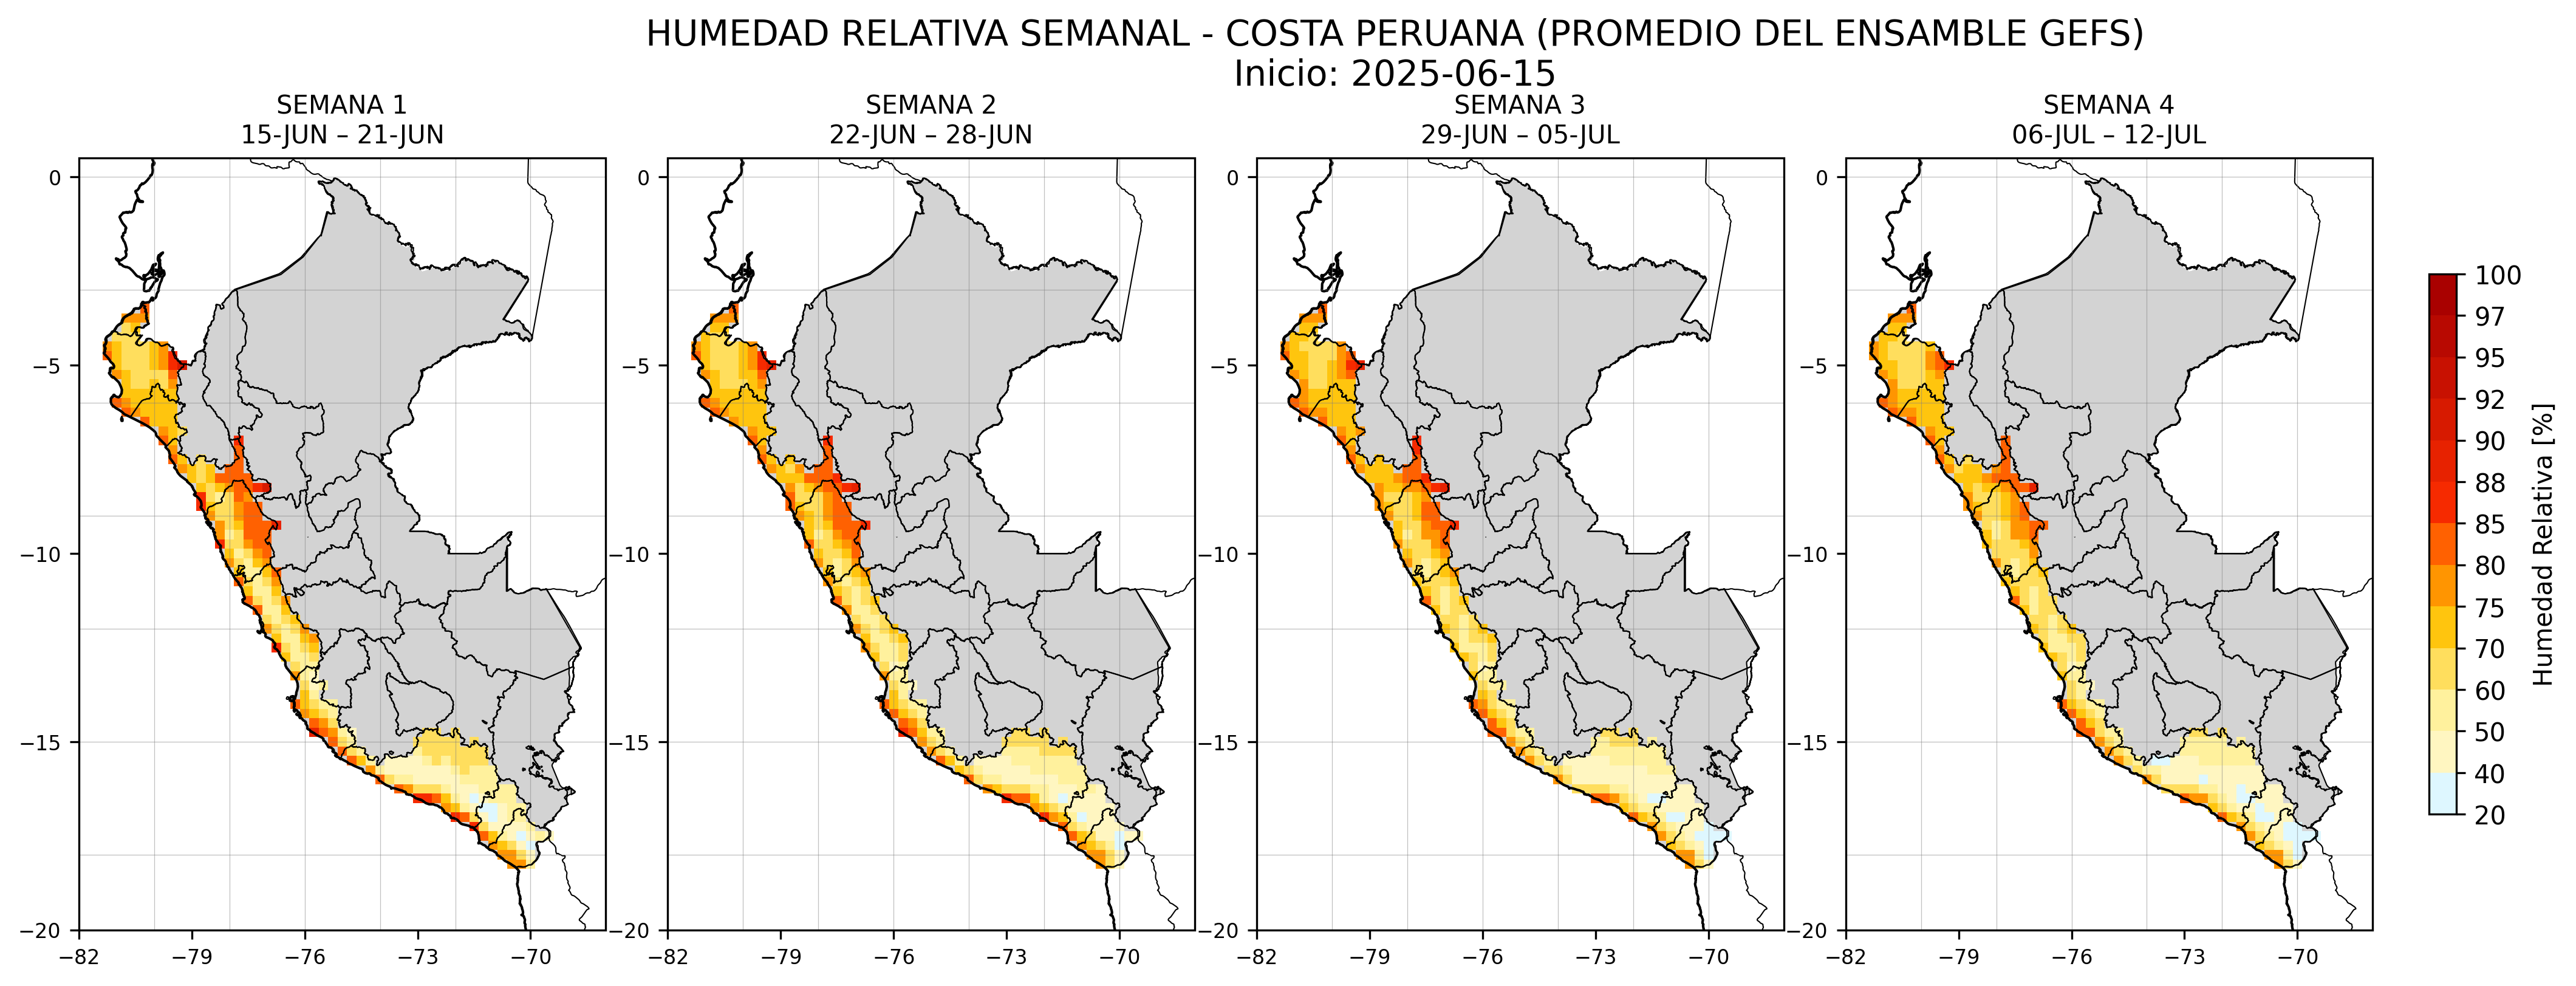

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
import numpy as np
import tempfile
import requests
import os
from shapely.geometry import Point

# --- Parámetro de fecha de inicio manual (opcional)
fecha_manual = "2025-06-15"  # Formato: YYYY-MM-DD. Usa None para fecha más reciente.

shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shx",
}
shapefiles_extra = {
    "SUDA_NUEVO_SIN_PERU_3.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDA_NUEVO_SIN_PERU_3.shp",
    "SUDA_NUEVO_SIN_PERU_3.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDA_NUEVO_SIN_PERU_3.dbf",
    "SUDA_NUEVO_SIN_PERU_3.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDA_NUEVO_SIN_PERU_3.shx",
}
tempdir = tempfile.mkdtemp()
for files in [shapefiles, shapefiles_extra]:
    for filename, url in files.items():
        r = requests.get(url)
        with open(os.path.join(tempdir, filename), "wb") as f:
            f.write(r.content)
gdf_peru = gpd.read_file(os.path.join(tempdir, "departamentos.shp"))
gdf_suda = gpd.read_file(os.path.join(tempdir, "SUDA_NUEVO_SIN_PERU_3.shp"))

dptos_costa = ["TUMBES", "PIURA", "LAMBAYEQUE", "LA LIBERTAD", "ANCASH",
               "LIMA", "ICA", "AREQUIPA", "MOQUEGUA", "TACNA"]
gdf_costa = gdf_peru[gdf_peru["DEPARTAMEN"].isin(dptos_costa)]

# Leer GEFS
ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com")

if fecha_manual:
    fecha_manual_dt = np.datetime64(fecha_manual)
    if fecha_manual_dt in ds.init_time:
        print("Usando init_time manual:", fecha_manual)
        ds = ds.sel(init_time=fecha_manual_dt)
    else:
        raise ValueError(f"La fecha {fecha_manual} no está disponible en el dataset.")
else:
    latest_init = ds.init_time.max().values
    print("Usando init_time más reciente:", pd.to_datetime(latest_init).strftime("%Y-%m-%d"))
    ds = ds.sel(init_time=latest_init)

ds = ds.sel(latitude=slice(0.5, -19.5), longitude=slice(-82, -68))
ds = ds.sel(lead_time=slice("0h", "27d"))

rh = ds["relative_humidity_2m"]
forecast_time = ds.init_time + ds.lead_time
rh = rh.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
if rh.max() <= 1:
    rh *= 100
rh_daily = rh.groupby("forecast_time.date").mean(dim="forecast_time")
rh_mean = rh_daily.mean(dim="ensemble_member")

semanas = {
    "SEMANA 1": slice(0, 7),
    "SEMANA 2": slice(7, 14),
    "SEMANA 3": slice(14, 21),
    "SEMANA 4": slice(21, 28),
}

levels = [20, 40, 50, 60, 70, 75, 80, 85, 88, 90, 92, 95, 97, 100]
colors = ['#DEF7FF', '#FFF6C1', '#FFF19D', '#FFDE5D', '#FFC50E',
          '#FF9501', '#FF6101', '#F62A00', '#E72200', '#D71A00',
          '#C81101', '#B80901', '#A90100']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(colors))

extent = [-82, -68, -19.5, 0.5]
x_ticks = np.arange(-82, -67, 3)
y_ticks = np.arange(-20, 2, 5)

fig, axes = plt.subplots(1, 4, figsize=(20, 5.5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
fig.subplots_adjust(wspace=0.02, hspace=0.01)

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    rh_avg = rh_mean.isel(date=rango).mean("date")
    lon2d, lat2d = np.meshgrid(rh_avg.longitude.values, rh_avg.latitude.values)
    points = [Point(x, y) for x, y in zip(lon2d.ravel(), lat2d.ravel())]
    mask = np.array([gdf_costa.unary_union.contains(p) for p in points]).reshape(lat2d.shape)
    rh_masked = np.where(mask, rh_avg.values, np.nan)

    ax.set_extent(extent)
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)
    ax.gridlines(draw_labels=False, linewidth=0.3, color='gray', alpha=0.5)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    gdf_suda.plot(ax=ax, color='white', linewidth=0)

    m = ax.pcolormesh(rh_avg.longitude, rh_avg.latitude, rh_masked,
                      cmap=cmap, norm=norm, shading='nearest')

    fechas = rh_mean.date.values[rango]
    start = pd.to_datetime(str(fechas[0])).strftime("%d-%b").upper()
    end = pd.to_datetime(str(fechas[-1])).strftime("%d-%b").upper()
    ax.set_title(f"{semana}\n{start} – {end}", fontsize=10)

cbar = fig.colorbar(m, ax=axes.ravel().tolist(), orientation='vertical',
                    shrink=0.7, pad=0.02, ticks=levels)
cbar.set_label("Humedad Relativa [%]", fontsize=10)

fecha_titulo = fecha_manual if fecha_manual else pd.to_datetime(ds.init_time.values).strftime('%Y-%m-%d')
plt.suptitle(f"HUMEDAD RELATIVA SEMANAL - COSTA PERUANA (PROMEDIO DEL ENSAMBLE GEFS)\nInicio: {fecha_titulo}", fontsize=14, y=1.02)
plt.savefig(f"rh_costa_peru_{fecha_titulo.replace('-', '')}.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


/tmp/ipython-input-2-60506642.py:40: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com")
/tmp/ipython-input-2-60506642.py:40: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com")


Usando init_time: 2025-06-25


/tmp/ipython-input-2-60506642.py:83: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask = np.array([gdf_costa.unary_union.contains(p) for p in points]).reshape(lat2d.shape)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/tmp/ipython-input-2-60506642.py:83: DeprecationWarning: The 'unary_union' attr

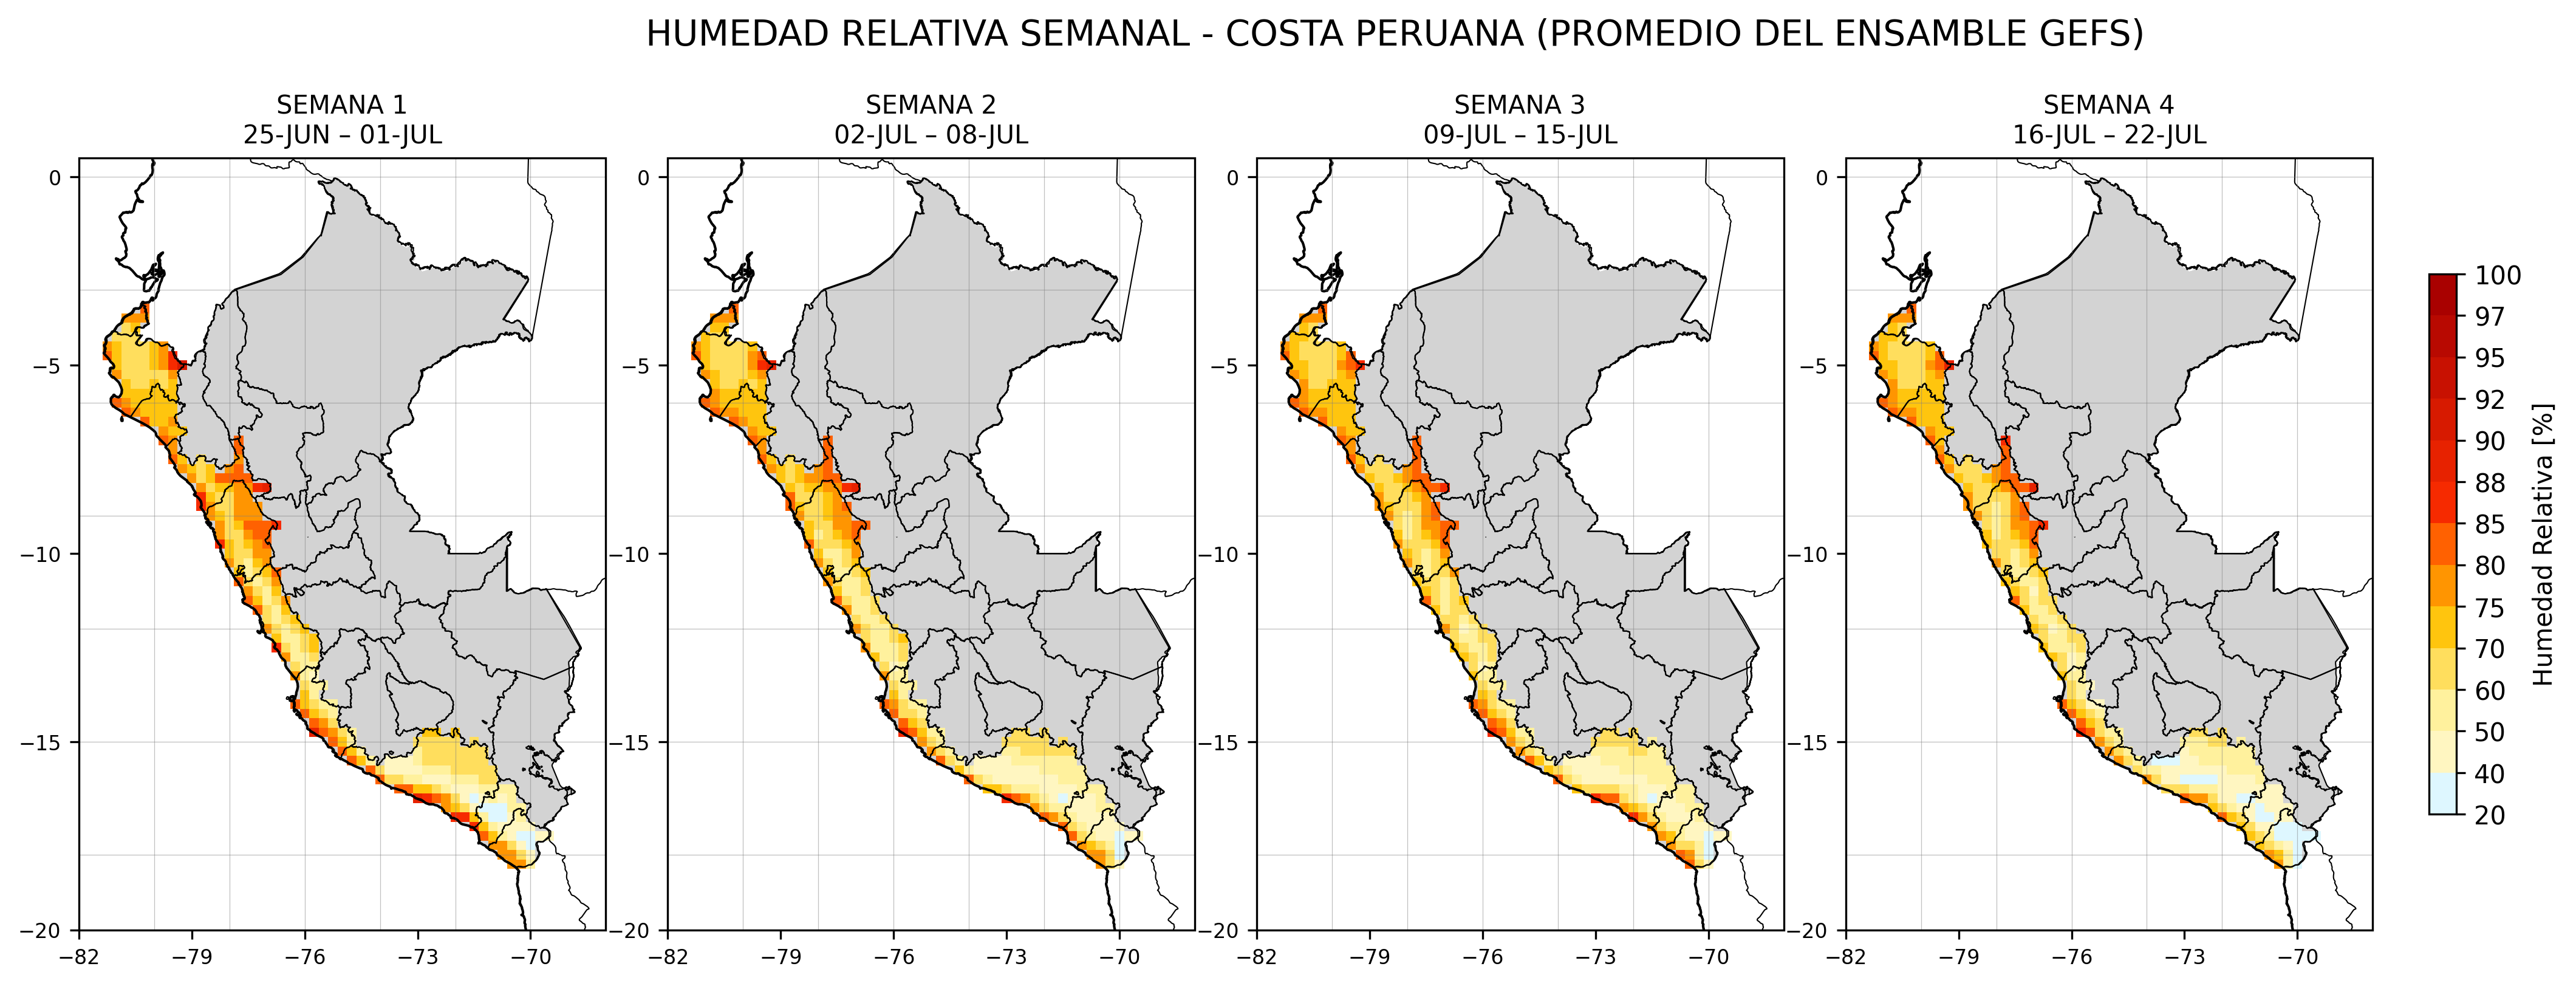

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
import numpy as np
import tempfile
import requests
import os
from shapely.geometry import Point

# --- Descargar shapefiles
shapefiles = {
    "departamentos.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shp",
    "departamentos.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.dbf",
    "departamentos.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/DEPARTAMENTOS.shx",
}
shapefiles_extra = {
    "SUDA_NUEVO_SIN_PERU_3.shp": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDA_NUEVO_SIN_PERU_3.shp",
    "SUDA_NUEVO_SIN_PERU_3.dbf": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDA_NUEVO_SIN_PERU_3.dbf",
    "SUDA_NUEVO_SIN_PERU_3.shx": "https://raw.githubusercontent.com/SMN-SENAMHI/Materiales/main/shape/SUDA_NUEVO_SIN_PERU_3.shx",
}
tempdir = tempfile.mkdtemp()
for files in [shapefiles, shapefiles_extra]:
    for filename, url in files.items():
        r = requests.get(url)
        with open(os.path.join(tempdir, filename), "wb") as f:
            f.write(r.content)
gdf_peru = gpd.read_file(os.path.join(tempdir, "departamentos.shp"))
gdf_suda = gpd.read_file(os.path.join(tempdir, "SUDA_NUEVO_SIN_PERU_3.shp"))

# --- Filtrar departamentos costeros
dptos_costa = ["TUMBES", "PIURA", "LAMBAYEQUE", "LA LIBERTAD", "ANCASH",
               "LIMA", "ICA", "AREQUIPA", "MOQUEGUA", "TACNA"]
gdf_costa = gdf_peru[gdf_peru["DEPARTAMEN"].isin(dptos_costa)]

# --- Leer GEFS Zarr
ds = xr.open_zarr("https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com")
latest_init = ds.init_time.max().values
print("Usando init_time:", pd.to_datetime(latest_init).strftime("%Y-%m-%d"))
ds = ds.sel(init_time=latest_init).sel(latitude=slice(0.5, -19.5), longitude=slice(-82, -68))
ds = ds.sel(lead_time=slice("0h", "27d"))

# --- Procesar humedad relativa
rh = ds["relative_humidity_2m"]
forecast_time = ds.init_time + ds.lead_time
rh = rh.assign_coords(forecast_time=forecast_time).swap_dims({"lead_time": "forecast_time"})
if rh.max() <= 1:
    rh *= 100
rh_daily = rh.groupby("forecast_time.date").mean(dim="forecast_time")
rh_mean = rh_daily.mean(dim="ensemble_member")

# --- Definir semanas
semanas = {
    "SEMANA 1": slice(0, 7),
    "SEMANA 2": slice(7, 14),
    "SEMANA 3": slice(14, 21),
    "SEMANA 4": slice(21, 28),
}

# --- Definir niveles y colores personalizados
levels = [20, 40, 50, 60, 70, 75, 80, 85, 88, 90, 92, 95, 97, 100]
colors = ['#DEF7FF', '#FFF6C1', '#FFF19D', '#FFDE5D', '#FFC50E',
          '#FF9501', '#FF6101', '#F62A00', '#E72200', '#D71A00',
          '#C81101', '#B80901', '#A90100']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(colors))

extent = [-82, -68, -19.5, 0.5]
x_ticks = np.arange(-82, -67, 3)
y_ticks = np.arange(-20, 2, 5)

# --- Gráfico
fig, axes = plt.subplots(1, 4, figsize=(20, 5.5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)
fig.subplots_adjust(wspace=0.02, hspace=0.01)

for i, (ax, (semana, rango)) in enumerate(zip(axes, semanas.items())):
    rh_avg = rh_mean.isel(date=rango).mean("date")
    lon2d, lat2d = np.meshgrid(rh_avg.longitude.values, rh_avg.latitude.values)
    points = [Point(x, y) for x, y in zip(lon2d.ravel(), lat2d.ravel())]
    mask = np.array([gdf_costa.unary_union.contains(p) for p in points]).reshape(lat2d.shape)
    rh_masked = np.where(mask, rh_avg.values, np.nan)

    ax.set_extent(extent)
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)
    ax.gridlines(draw_labels=False, linewidth=0.3, color='gray', alpha=0.5)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    gdf_peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    gdf_suda.plot(ax=ax, color='white', linewidth=0)

    m = ax.pcolormesh(rh_avg.longitude, rh_avg.latitude, rh_masked,
                      cmap=cmap, norm=norm, shading='nearest')

    fechas = rh_mean.date.values[rango]
    start = pd.to_datetime(str(fechas[0])).strftime("%d-%b").upper()
    end = pd.to_datetime(str(fechas[-1])).strftime("%d-%b").upper()
    ax.set_title(f"{semana}\n{start} – {end}", fontsize=10)

# --- Barra de colores
cbar = fig.colorbar(m, ax=axes.ravel().tolist(), orientation='vertical',
                    shrink=0.7, pad=0.02, ticks=levels)
cbar.set_label("Humedad Relativa [%]", fontsize=10)

# --- Título general y guardar
plt.suptitle("HUMEDAD RELATIVA SEMANAL - COSTA PERUANA (PROMEDIO DEL ENSAMBLE GEFS)", fontsize=14, y=1.02)
plt.savefig(f"rh_costa_peru_{pd.to_datetime(latest_init).strftime('%Y%m%d')}.png", bbox_inches='tight', pad_inches=0.05)
plt.show()
